# Global Imports

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas import read_csv
import math, collections
from tensorflow import keras
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, ConvLSTM2D, Conv1D, Conv2D, Dropout, MaxPooling2D, MaxPooling1D
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy import io
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import datetime
from keras.metrics import RootMeanSquaredError
debug = True
useGPU = True

## N-Beats Import
https://github.com/philipperemy/n-beats

Potentially a good one for time series

In [122]:
!pip install nbeats-keras
from nbeats_keras.model import NBeatsNet as NBeatsKeras

# Setup the GPU

In [123]:
# used to load and test for a GPU
if useGPU:
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Import the Data

In [124]:
data = io.loadmat('data.mat')
data = data["Data"]
labels = np.loadtxt('label.csv', delimiter="\n", dtype=int)

# Fix the unbalanced data with oversampling

In [125]:
random_over_sampler = RandomOverSampler(random_state=1337)
smoteen = SMOTEENN(random_state=1337)
data, labels = random_over_sampler.fit_resample(data,labels)
#data, labels = smoteen.fit_resample(data,labels)
labels = np.array(np.ravel(labels))

# Split the data

In [126]:
X_train, X_test, y_train, y_test = train_test_split(data, labels)
y_train = np.array(y_train)
num_classes = len(np.unique(y_train))

# Reshape the dataset

In [127]:
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))

In [128]:
print (X_train.shape)
print (X_test.shape)

(202, 1, 3000)
(68, 1, 3000)


# The MLP Model

## Define the base model

In [129]:
mlp_model = Sequential()
mlp_model.add(Dense(600, input_shape=(None,3000),activation='relu'))
mlp_model.add(Dense(500, activation='relu'))
mlp_model.add(Dense(400, activation='relu'))
mlp_model.add(Dense(300, activation='relu'))
mlp_model.add(Dense(200, activation='relu'))
mlp_model.add(Dense(100, activation='relu'))
mlp_model.add(Dense(50, activation='relu'))
mlp_model.add(Dense(25, activation='relu'))
mlp_model.add(Dense(10, activation='relu'))
mlp_model.add(Dense(1))

## Compile the model

In [130]:
mlp_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy','mean_squared_error',RootMeanSquaredError()])
mlp_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, None, 600)         1800600   
                                                                 
 dense_67 (Dense)            (None, None, 500)         300500    
                                                                 
 dense_68 (Dense)            (None, None, 400)         200400    
                                                                 
 dense_69 (Dense)            (None, None, 300)         120300    
                                                                 
 dense_70 (Dense)            (None, None, 200)         60200     
                                                                 
 dense_71 (Dense)            (None, None, 100)         20100     
                                                                 
 dense_72 (Dense)            (None, None, 50)         

## The Callback for ealry stopapge

In [131]:
callback_mlp = [
    keras.callbacks.EarlyStopping(monitor="root_mean_squared_error", patience=15, verbose=1),
]

## Train the MLP Model

In [132]:
before_mlp = datetime.utcnow()
print ("Start time (UTC): "+str(before_mlp))
with tf.device('/device:GPU:0'):
    # fit the model
  mlp_history = mlp_model.fit(X_train, y_train, epochs=250, 
            verbose=1, 
            workers=8, # multithread
            callbacks=callback_mlp, 
            validation_data=(X_test,y_test),
            use_multiprocessing=True) # multithread
# get the stop time
after_mlp = datetime.utcnow()
print ("Stop Time (UTC): "+str(after_mlp))

# do the math for the time difference
print ("Run time: "+str(after_mlp-before_mlp))

Start time (UTC): 2022-04-14 20:33:13.149884
Epoch 1/250
7/7 [==============================] - 2s 83ms/step - loss: 0.5542 - accuracy: 0.4703 - mean_squared_error: 0.5542 - root_mean_squared_error: 0.7414 - val_loss: 0.5045 - val_accuracy: 0.4853 - val_mean_squared_error: 0.5045 - val_root_mean_squared_error: 0.7014
Epoch 2/250
7/7 [==============================] - 0s 13ms/step - loss: 0.5070 - accuracy: 0.4703 - mean_squared_error: 0.5070 - root_mean_squared_error: 0.7133 - val_loss: 0.4623 - val_accuracy: 0.4853 - val_mean_squared_error: 0.4623 - val_root_mean_squared_error: 0.6714
Epoch 3/250
7/7 [==============================] - 0s 11ms/step - loss: 0.4339 - accuracy: 0.4703 - mean_squared_error: 0.4339 - root_mean_squared_error: 0.6578 - val_loss: 0.3011 - val_accuracy: 0.4853 - val_mean_squared_error: 0.3011 - val_root_mean_squared_error: 0.5434
Epoch 4/250
7/7 [==============================] - 0s 11ms/step - loss: 0.2718 - accuracy: 0.4959 - mean_squared_error: 0.2718 - root

# The CNN Model

## Define the Model

In [133]:
# to use GPU with tf.device('/device:GPU:0'):
cnn_model = Sequential()
cnn_model.add(Conv1D(256, (1), activation='relu', input_shape=(None, 3000)))
cnn_model.add(MaxPooling1D((1)))
cnn_model.add(Conv1D(128, (1), activation='relu'))
cnn_model.add(MaxPooling1D((1)))
cnn_model.add(Conv1D(64, (1), activation='relu'))
cnn_model.add(MaxPooling1D((1)))
cnn_model.add(Conv1D(32, (1), activation='relu'))
cnn_model.add(MaxPooling1D((1)))
cnn_model.add(Conv1D(16, (1), activation='relu'))
cnn_model.add(MaxPooling1D((1)))
cnn_model.add(Conv1D(8, (1), activation='relu'))
cnn_model.add(Dense(1))

## Compile the Model

In [134]:
cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy','mean_squared_error',RootMeanSquaredError()])
cnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, None, 256)         768256    
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, None, 256)        0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, None, 128)         32896     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, None, 128)        0         
 g1D)                                                            
                                                                 
 conv1d_20 (Conv1D)          (None, None, 64)          8256      
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, None, 64)       

## The Callback for early stoppage

In [135]:
callback_cnn = [
    keras.callbacks.EarlyStopping(monitor="root_mean_squared_error", patience=20, verbose=1),
]

## Train the CNN Model

In [136]:
before_cnn = datetime.utcnow()
print ("Start time (UTC): "+str(before_cnn))
with tf.device('/device:GPU:0'):
    # fit the model
  cnn_history = cnn_model.fit(X_train, y_train, epochs=250, 
            verbose=1, 
            workers=8, # multithread
            callbacks=callback_cnn, 
            validation_data=(X_test,y_test),
            use_multiprocessing=True) # multithread
# get the stop time
after_cnn = datetime.utcnow()
print ("Stop Time (UTC): "+str(after_cnn))

# do the math for the time difference
print ("Run time: "+str(after_cnn-before_cnn))

Start time (UTC): 2022-04-14 20:33:22.522194
Epoch 1/250
7/7 [==============================] - 1s 48ms/step - loss: 0.5023 - accuracy: 0.4703 - mean_squared_error: 0.5023 - root_mean_squared_error: 0.7107 - val_loss: 0.3998 - val_accuracy: 0.4853 - val_mean_squared_error: 0.3998 - val_root_mean_squared_error: 0.6244
Epoch 2/250
7/7 [==============================] - 0s 12ms/step - loss: 0.3326 - accuracy: 0.4734 - mean_squared_error: 0.3326 - root_mean_squared_error: 0.5779 - val_loss: 0.2743 - val_accuracy: 0.4917 - val_mean_squared_error: 0.2743 - val_root_mean_squared_error: 0.5251
Epoch 3/250
7/7 [==============================] - 0s 17ms/step - loss: 0.3254 - accuracy: 0.4978 - mean_squared_error: 0.3254 - root_mean_squared_error: 0.5677 - val_loss: 0.2887 - val_accuracy: 0.5147 - val_mean_squared_error: 0.2887 - val_root_mean_squared_error: 0.5401
Epoch 4/250
7/7 [==============================] - 0s 14ms/step - loss: 0.2689 - accuracy: 0.5003 - mean_squared_error: 0.2689 - root

# The LSTM Model

## Define the model

In [137]:
seq_size=3000
lstm_model=Sequential()
lstm_model.add(LSTM(50,activation='relu', return_sequences=True, input_shape=(None,seq_size)))
lstm_model.add(LSTM(50,activation='relu'))
lstm_model.add(Dense(32))
lstm_model.add(Dense(32))
lstm_model.add(Dense(32))
lstm_model.add(Dense(32))
lstm_model.add(Dense(32))
lstm_model.add(Dense(32))
lstm_model.add(Dense(32))
lstm_model.add(Dense(32))
lstm_model.add(Dense(32))
lstm_model.add(Dense(32))
lstm_model.add(Dense(1))

## Compile the model

In [138]:
lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy','mean_squared_error',RootMeanSquaredError()])

## The callback for early stoppage

In [139]:
callback_lstm = [
    keras.callbacks.EarlyStopping(monitor="root_mean_squared_error", patience=20, verbose=1),
]

## Train the LSTM Model

In [140]:
# to use GPU with tf.device('/device:GPU:0'):
with tf.device('/device:GPU:0'):
  before_lstm = datetime.utcnow()
  print ("Start time (UTC): "+str(before_lstm))
  with tf.device('/device:GPU:0'):
      # fit the model
    lstm_history = lstm_model.fit(X_train, y_train, epochs=250, 
              verbose=1, 
              workers=8, # multithread
              callbacks=callback_lstm, 
              validation_data=(X_test,y_test),
              use_multiprocessing=True) # multithread
  # get the stop time
  after_lstm = datetime.utcnow()
  print ("Stop Time (UTC): "+str(after_lstm))

  # do the math for the time difference
  print ("Run time: "+str(after_lstm-before_lstm))

Start time (UTC): 2022-04-14 20:33:48.417982
Epoch 1/250
7/7 [==============================] - 3s 75ms/step - loss: 0.3790 - accuracy: 0.5000 - mean_squared_error: 0.3790 - root_mean_squared_error: 0.6157 - val_loss: 0.5406 - val_accuracy: 0.5147 - val_mean_squared_error: 0.5406 - val_root_mean_squared_error: 0.7352
Epoch 2/250
7/7 [==============================] - 0s 15ms/step - loss: 0.3075 - accuracy: 0.5347 - mean_squared_error: 0.3075 - root_mean_squared_error: 0.5545 - val_loss: 0.2661 - val_accuracy: 0.4853 - val_mean_squared_error: 0.2661 - val_root_mean_squared_error: 0.5159
Epoch 3/250
7/7 [==============================] - 0s 16ms/step - loss: 0.2721 - accuracy: 0.4703 - mean_squared_error: 0.2721 - root_mean_squared_error: 0.5217 - val_loss: 0.2556 - val_accuracy: 0.4853 - val_mean_squared_error: 0.2556 - val_root_mean_squared_error: 0.5055
Epoch 4/250
7/7 [==============================] - 0s 17ms/step - loss: 0.2527 - accuracy: 0.4802 - mean_squared_error: 0.2527 - root

# The N-BEATS Model
https://github.com/philipperemy/n-beats

## Define the Model

In [141]:
nbeats_model = NBeatsKeras(backcast_length=1)

## Compile the Model

In [142]:
nbeats_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy','mean_squared_error',RootMeanSquaredError()])

## The callback for early stoppage

In [143]:
callback_nbeats = [
    keras.callbacks.EarlyStopping(monitor="root_mean_squared_error", patience=20, verbose=1),
]

## Train the N-BEATS Model

In [144]:
# to use GPU with tf.device('/device:GPU:0'):
with tf.device('/device:GPU:0'):
  before_nbeats = datetime.utcnow()
  print ("Start time (UTC): "+str(before_nbeats))
  with tf.device('/device:GPU:0'):
      # fit the model
    nbeats_history = nbeats_model.fit(X_train, y_train, epochs=250, 
              verbose=1, 
              workers=8, # multithread
              callbacks=callback_nbeats, 
              validation_data=(X_test,y_test),
              use_multiprocessing=True) # multithread
  # get the stop time
  after_nbeats = datetime.utcnow()
  print ("Stop Time (UTC): "+str(after_nbeats))

  # do the math for the time difference
  print ("Run time: "+str(after_nbeats-before_nbeats))

Start time (UTC): 2022-04-14 20:34:11.331860
Epoch 1/250
7/7 [==============================] - 2s 78ms/step - loss: 0.4059 - accuracy: 0.4505 - mean_squared_error: 0.4059 - root_mean_squared_error: 0.6386 - val_loss: 0.2671 - val_accuracy: 0.5147 - val_mean_squared_error: 0.2671 - val_root_mean_squared_error: 0.5204
Epoch 2/250
7/7 [==============================] - 0s 11ms/step - loss: 0.2630 - accuracy: 0.4406 - mean_squared_error: 0.2630 - root_mean_squared_error: 0.5136 - val_loss: 0.2541 - val_accuracy: 0.4853 - val_mean_squared_error: 0.2541 - val_root_mean_squared_error: 0.5028
Epoch 3/250
7/7 [==============================] - 0s 12ms/step - loss: 0.2513 - accuracy: 0.5012 - mean_squared_error: 0.2513 - root_mean_squared_error: 0.5016 - val_loss: 0.2557 - val_accuracy: 0.5147 - val_mean_squared_error: 0.2557 - val_root_mean_squared_error: 0.5079
Epoch 4/250
7/7 [==============================] - 0s 10ms/step - loss: 0.2547 - accuracy: 0.5297 - mean_squared_error: 0.2547 - root

# Plot the Metrics

## The base plot function

In [145]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot Metrics code from here https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

def plot_metrics(history):
  metrics = ['loss','mean_squared_error','accuracy','root_mean_squared_error','val_loss','val_accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,3,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Training Data')

    plt.xlabel('Epoch')
    plt.ylabel(name)

    plt.legend();

def generate_metrics(history):
  metrics = ['loss','mean_squared_error','accuracy','root_mean_squared_error','val_loss','val_accuracy']
  for n, metric in enumerate(metrics):
    print (metric)
    print ("Min: %.3f"% np.min(history.history[metric]))
    print ("Max: %.3f"% np.max(history.history[metric]))
    print ("Average: %.3f"% np.average(history.history[metric]))
    print ("Mean: %.3f"% np.mean(history.history[metric]))
    print ("\n")

## Metrics for CNN

loss
Min: 0.248
Max: 0.502
Average: 0.257
Mean: 0.257


mean_squared_error
Min: 0.248
Max: 0.502
Average: 0.257
Mean: 0.257


accuracy
Min: 0.456
Max: 0.539
Average: 0.498
Mean: 0.498


root_mean_squared_error
Min: 0.498
Max: 0.711
Average: 0.506
Mean: 0.506


val_loss
Min: 0.250
Max: 0.400
Average: 0.258
Mean: 0.258


val_accuracy
Min: 0.484
Max: 0.516
Average: 0.498
Mean: 0.498




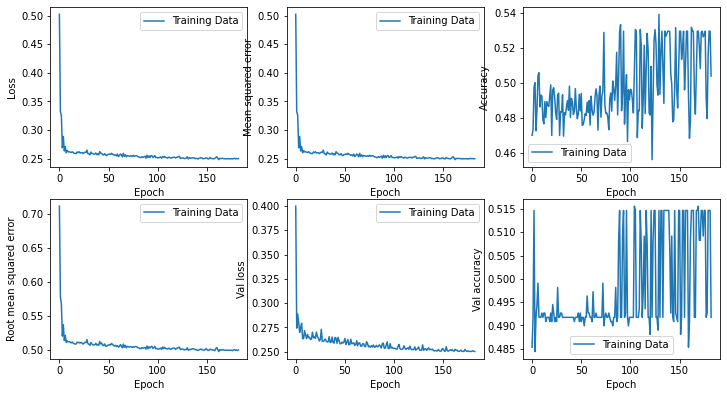

In [146]:
plot_metrics(cnn_history)
generate_metrics(cnn_history)

## Mertric for MLP

loss
Min: 0.257
Max: 0.554
Average: 0.282
Mean: 0.282


mean_squared_error
Min: 0.257
Max: 0.554
Average: 0.282
Mean: 0.282


accuracy
Min: 0.460
Max: 0.564
Average: 0.491
Mean: 0.491


root_mean_squared_error
Min: 0.508
Max: 0.741
Average: 0.529
Mean: 0.529


val_loss
Min: 0.258
Max: 0.505
Average: 0.277
Mean: 0.277


val_accuracy
Min: 0.484
Max: 0.515
Average: 0.495
Mean: 0.495




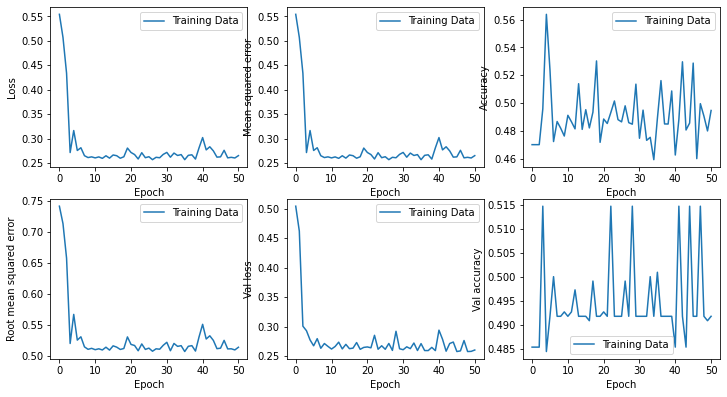

In [147]:
plot_metrics(mlp_history)
generate_metrics(mlp_history)

## Metrics for LSTM

loss
Min: 0.043
Max: 0.379
Average: 0.133
Mean: 0.133


mean_squared_error
Min: 0.043
Max: 0.379
Average: 0.133
Mean: 0.133


accuracy
Min: 0.470
Max: 0.960
Average: 0.801
Mean: 0.801


root_mean_squared_error
Min: 0.208
Max: 0.616
Average: 0.349
Mean: 0.349


val_loss
Min: 0.078
Max: 0.541
Average: 0.178
Mean: 0.178


val_accuracy
Min: 0.485
Max: 0.882
Average: 0.721
Mean: 0.721




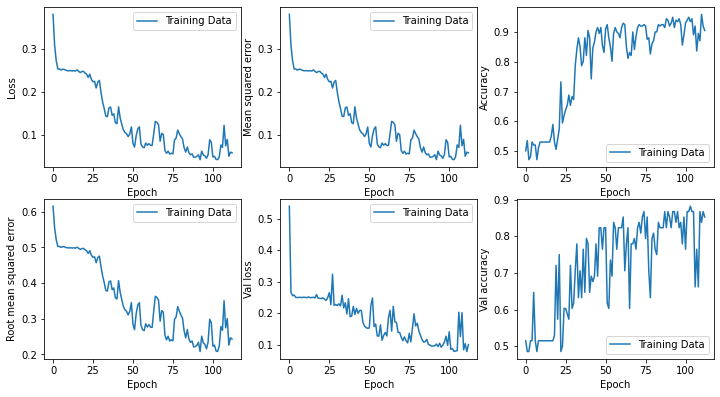

In [148]:
plot_metrics(lstm_history)
generate_metrics(lstm_history)

## Metrics for N-BEATS

loss
Min: 0.249
Max: 0.406
Average: 0.256
Mean: 0.256


mean_squared_error
Min: 0.249
Max: 0.406
Average: 0.256
Mean: 0.256


accuracy
Min: 0.430
Max: 0.531
Average: 0.505
Mean: 0.505


root_mean_squared_error
Min: 0.499
Max: 0.639
Average: 0.505
Mean: 0.505


val_loss
Min: 0.250
Max: 0.267
Average: 0.252
Mean: 0.252


val_accuracy
Min: 0.484
Max: 0.516
Average: 0.509
Mean: 0.509




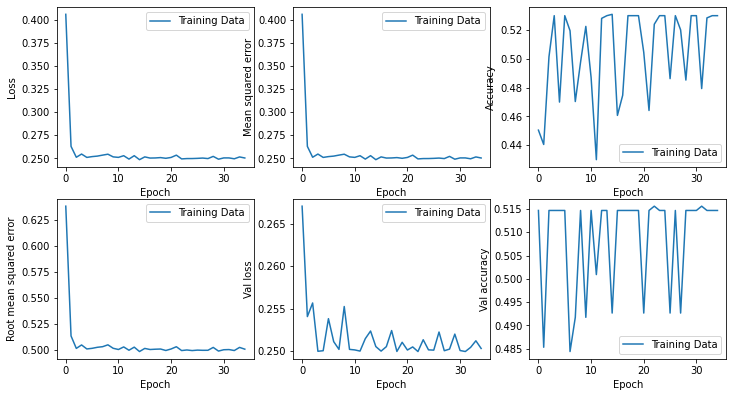

In [149]:
plot_metrics(nbeats_history)
generate_metrics(nbeats_history)